In [ ]:
import requests
import bz2

# Download compressed file
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
compressed_file = 'shape_predictor_68_face_landmarks.dat.bz2'
output_file = 'shape_predictor_68_face_landmarks.dat'

# Download the file
print("Downloading Dlib shape predictor...")
response = requests.get(url)
with open(compressed_file, 'wb') as f:
    f.write(response.content)
print("Download complete.")

# Extract the .bz2 file
print("Extracting...")
with bz2.BZ2File(compressed_file) as fr, open(output_file, 'wb') as fw:
    fw.write(fr.read())
print("Extraction complete.")


Exception in thread Thread-3 (attachment_entry):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.11/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise_exception("{0}() failed:", func.__name__, level="info")
  File "/usr/local/lib/python3.11/dist-packages/debugpy/server/api.py", line 141, in debug
    return func(address, settrace_kwargs, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/debugpy/server/ap

Download complete.
Extracting...
Extraction complete.


In [ ]:
import zipfile

# Download GloVe
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

print("Downloading GloVe embeddings...")
response = requests.get(glove_url)
with open(glove_zip, 'wb') as f:
    f.write(response.content)
print("Download complete.")

# Extract only glove.6B.50d.txt
print("Extracting glove.6B.50d.txt...")
with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extract('glove.6B.50d.txt')
print("Extraction complete.")


Download complete.
Extracting glove.6B.50d.txt...
Extraction complete.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jedidiahangekouakou/grid-corpus-dataset-for-training-lipnet")

print("Path to dataset files:", path)

100%|██████████| 12.6G/12.6G [10:02<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jedidiahangekouakou/grid-corpus-dataset-for-training-lipnet/versions/1


In [ ]:
import shutil
src = path
dst = 'content/data/'
shutil.move(src, dst)

'content/data/'

In [ ]:
!pip install tqdm


In [ ]:
import os
import numpy as np
import cv2
import dlib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
# from gensim.models import KeyedVectors

# ------------------------
# Step 1: Data Preparation
# ------------------------

# Dataset directory structure:
# dataset_root/speaker_id/*.mpg
# dataset_root/speaker_id/align/*.align

DATASET_ROOT = '/content/content/data/data'  # Update this path
VIDEO_EXT = '.mpg'
ALIGN_EXT = '.align'

# Extract all video-align pairs
def get_video_align_pairs(root_dir, max_files_per_speaker=50):
    pairs = []
    for speaker_folder in os.listdir(root_dir):
        speaker_path = os.path.join(root_dir, speaker_folder)
        if not os.path.isdir(speaker_path):
            continue
        video_dir = speaker_path
        align_dir = os.path.join(speaker_path, 'align')
        if not os.path.exists(align_dir):
            continue

        speaker_pairs = []
        for video_file in os.listdir(video_dir):
            if video_file.endswith(VIDEO_EXT):
                video_path = os.path.join(video_dir, video_file)
                align_file = os.path.join(align_dir, video_file.replace(VIDEO_EXT, ALIGN_EXT))
                if os.path.exists(align_file):
                    speaker_pairs.append((video_path, align_file))

        # Select up to max_files_per_speaker randomly or first 50
        speaker_pairs = random.sample(speaker_pairs, min(max_files_per_speaker, len(speaker_pairs)))

        pairs.extend(speaker_pairs)
    return pairs

# Use this updated function
video_align_pairs = get_video_align_pairs(DATASET_ROOT, max_files_per_speaker=50)
print(f"Total video-align pairs: {len(video_align_pairs)}")


# ------------------------------
# Step 2: Build Vocabulary
# ------------------------------

def extract_words(align_path):
    words = []
    with open(align_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3 and parts[2] != 'sil':
                words.append(parts[2].lower())
    return words

# Build vocab from all align files
vocab = set()
for _, align_file in video_align_pairs:
    vocab.update(extract_words(align_file))

word2idx = {word: idx + 1 for idx, word in enumerate(sorted(vocab))}
word2idx['<PAD>'] = 0
idx2word = {idx: word for word, idx in word2idx.items()}
print(f"Vocabulary size: {len(word2idx)}")

# ---------------------------------
# Step 3: Load GloVe Embeddings
# ---------------------------------

# Load pre-trained GloVe embeddings (50D)
# glove_model = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

# embedding_dim = 50
# embedding_matrix = []

# for word in sorted(word2idx, key=lambda x: word2idx[x]):
#     if word in glove_model:
#         embedding_matrix.append(glove_model[word])
#     else:
#         embedding_matrix.append(np.random.normal(scale=0.6, size=(embedding_dim,)))

# embedding_matrix = np.stack(embedding_matrix)
def load_glove_embeddings(file_path, word2idx, embedding_dim=50):
    embeddings = np.random.normal(scale=0.6, size=(len(word2idx), embedding_dim))
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if word in word2idx:
                embeddings[word2idx[word]] = np.array(parts[1:], dtype=np.float32)
    return embeddings

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt', word2idx)




# -----------------------------------
# Step 4: Lip Extraction (dlib)
# -----------------------------------

# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# def extract_lips(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     faces = detector(gray)
#     for face in faces:
#         landmarks = predictor(gray, face)
#         lips = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]
#         x, y = zip(*lips)
#         min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)
#         return cv2.resize(frame[min_y:max_y, min_x:max_x], (64, 64))
#     return None

# # ------------------------------
# # Step 5: Dataset Class
# # ------------------------------

# class LipReadingDataset(Dataset):
#     def __init__(self, video_align_pairs, word2idx):
#         self.video_align_pairs = video_align_pairs
#         self.word2idx = word2idx

#     def __len__(self):
#         return len(self.video_align_pairs)

#     def __getitem__(self, idx):
#         video_path, align_path = self.video_align_pairs[idx]

#         # Extract frames
#         cap = cv2.VideoCapture(video_path)
#         frames = []
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             lip = extract_lips(frame)
#             if lip is not None:
#                 frames.append(lip)
#         cap.release()

#         # Labels
#         words = extract_words(align_path)
#         labels = [self.word2idx[word] for word in words]

#         frames = torch.tensor(np.stack(frames)).permute(0, 3, 1, 2).float() / 255.0
#         labels = torch.tensor(labels)

#         return frames, labels

# # ------------------------------
# # Step 6: Seq2Seq Model
# # ------------------------------

# class CNNEncoder(nn.Module):
#     def __init__(self):
#         super(CNNEncoder, self).__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

#     def forward(self, x):
#         B, T, C, H, W = x.size()
#         x = x.view(B * T, C, H, W)
#         x = self.cnn(x)
#         x = x.view(B, T, -1)
#         return x

# class Seq2Seq(nn.Module):
#     def __init__(self, cnn_out_dim, embedding_matrix, hidden_dim, vocab_size):
#         super(Seq2Seq, self).__init__()
#         self.encoder = CNNEncoder()
#         self.lstm_enc = nn.LSTM(input_size=cnn_out_dim, hidden_size=hidden_dim, batch_first=True)
#         self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix).float(), freeze=False)
#         self.lstm_dec = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, vocab_size)

#     def forward(self, frames, labels):
#         enc_out = self.encoder(frames)
#         _, (h, c) = self.lstm_enc(enc_out)
#         embedded = self.embedding(labels)
#         dec_out, _ = self.lstm_dec(embedded, (h, c))
#         return self.fc(dec_out)

# # ------------------------------
# # Step 7: Training Loop
# # ------------------------------

# dataset = LipReadingDataset(video_align_pairs, word2idx)
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: x)

# # Detect device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using device: {device}')

# # Move model to device
# model = Seq2Seq(cnn_out_dim=64*16*16, embedding_matrix=embedding_matrix, hidden_dim=128, vocab_size=len(word2idx))
# model = model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])

# epoch_losses = []

# for epoch in range(5):
#     model.train()
#     total_loss = 0

#     # Wrap dataloader with tqdm for progress bar
#     pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

#     for batch in pbar:
#         frames, labels = zip(*batch)

#         # Pad sequences and move to device
#         frames = nn.utils.rnn.pad_sequence(frames, batch_first=True).to(device)
#         labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=word2idx['<PAD>']).to(device)

#         outputs = model(frames, labels[:, :-1])
#         loss = criterion(outputs.reshape(-1, outputs.shape[-1]), labels[:, 1:].reshape(-1))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # Update progress bar description with batch loss
#         pbar.set_postfix({"Batch Loss": loss.item()})

#     avg_loss = total_loss / len(dataloader)
#     epoch_losses.append(avg_loss)
#     print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}")




Total video-align pairs: 1650
Vocabulary size: 53


Improved:

In [ ]:
import os
import cv2
import numpy as np
import dlib
from tqdm import tqdm
# Paths
DATASET_ROOT = '/content/content/data/data'
VIDEO_EXT = '.mpg'

# Dlib models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def extract_lips(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        lips = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]
        x, y = zip(*lips)
        min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)
        return cv2.resize(frame[min_y:max_y, min_x:max_x], (64, 64))
    return None

# Assuming video_align_pairs is already defined from get_video_align_pairs()


video_files = [video_path for video_path, _ in video_align_pairs]  # Use only selected videos

for video_path in tqdm(video_files, desc="Preprocessing lips"):
    lip_path = video_path.replace('.mpg', '_lips.npy')
    if os.path.exists(lip_path):
        continue
    cap = cv2.VideoCapture(video_path)
    lips = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        lip = extract_lips(frame)
        if lip is not None:
            lips.append(lip)
    cap.release()
    if lips:
        np.save(lip_path, np.stack(lips))


Preprocessing lips: 100%|██████████| 1650/1650 [28:42<00:00,  1.04s/it]


In [ ]:
import os
import shutil
from tqdm import tqdm

DATASET_ROOT = '/content/content/data/data'  # Original dataset location
PREPROCESSED_DIR = '/content/preprocessed_lips'  # Destination directory

# Create preprocessed directory
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

# Walk through dataset to find .npy files
for speaker in os.listdir(DATASET_ROOT):
    speaker_path = os.path.join(DATASET_ROOT, speaker)
    if not os.path.isdir(speaker_path):
        continue
    for file in os.listdir(speaker_path):
        if file.endswith('_lips.npy'):
            src_path = os.path.join(speaker_path, file)
            dest_speaker_dir = os.path.join(PREPROCESSED_DIR, speaker)
            os.makedirs(dest_speaker_dir, exist_ok=True)
            dest_path = os.path.join(dest_speaker_dir, file)
            shutil.move(src_path, dest_path)

print("All preprocessed .npy files moved successfully!")


All preprocessed .npy files moved successfully!


In [ ]:
import shutil

# Source folder and output zip file name
source_folder = '/content/preprocessed_lips'
output_zip = '/content/preprocessed_lips_backup.zip'

# Create zip file (without altering original folder)
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_folder)

print(f"Zip file created: {output_zip}")


Zip file created: /content/preprocessed_lips_backup.zip


In [ ]:
import os
import shutil
from tqdm import tqdm

PREPROCESSED_DIR = '/content/preprocessed_lips'  # Current location of .npy files
DATASET_ROOT = '/content/content/data/data'      # Original dataset location

# Walk through preprocessed_lips
for speaker in os.listdir(PREPROCESSED_DIR):
    speaker_pre_dir = os.path.join(PREPROCESSED_DIR, speaker)
    if not os.path.isdir(speaker_pre_dir):
        continue
    for file in os.listdir(speaker_pre_dir):
        if file.endswith('_lips.npy'):
            src_path = os.path.join(speaker_pre_dir, file)
            dest_speaker_dir = os.path.join(DATASET_ROOT, speaker)
            os.makedirs(dest_speaker_dir, exist_ok=True)  # Ensure the speaker folder exists
            dest_path = os.path.join(dest_speaker_dir, file)
            shutil.move(src_path, dest_path)

print("Preprocessed .npy files moved back to original dataset structure!")


Preprocessed .npy files moved back to original dataset structure!


In [ ]:
video_align_pairs[:2]

[('/content/content/data/data/s4_processed/lgal6s.mpg',
  '/content/content/data/data/s4_processed/align/lgal6s.align'),
 ('/content/content/data/data/s4_processed/lrbe6a.mpg',
  '/content/content/data/data/s4_processed/align/lrbe6a.align')]

In [ ]:
import zipfile
import os

# Paths
zip_file_path = '/content/preprocessed_lips_backup.zip'  # Your zip file path
extract_to = '/content/preprocessed_lips_'                # Destination folder

# Extract
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")


Extracted to: /content/preprocessed_lips_


In [ ]:
import os

PREPROCESSED_DIR = '/content/preprocessed_lips_'       # Location of preprocessed .npy files
ALIGN_ROOT = '/content/content/data/data'             # Original dataset root (align files here)
VIDEO_EXT = '_lips.npy'
ALIGN_EXT = '.align'

video_align_pairs = []

# Walk through preprocessed lips
for speaker in os.listdir(PREPROCESSED_DIR):
    speaker_pre_dir = os.path.join(PREPROCESSED_DIR, speaker)
    if not os.path.isdir(speaker_pre_dir):
        continue
    for file in os.listdir(speaker_pre_dir):
        if file.endswith(VIDEO_EXT):
            npy_path = os.path.join(speaker_pre_dir, file)

            # Convert 'lgal6s_lips.npy' -> 'lgal6s.align'
            base_name = file.replace('_lips.npy', '')
            align_path = os.path.join(ALIGN_ROOT, speaker, 'align', base_name + ALIGN_EXT)

            if os.path.exists(align_path):
                video_align_pairs.append((npy_path, align_path))
            else:
                print(f"Missing align file for {npy_path}")

print(f"Total video-align pairs: {len(video_align_pairs)}")


Total video-align pairs: 1648


[('/content/preprocessed_lips_/s4_processed/bwbt3n_lips.npy',
  '/content/content/data/data/s4_processed/align/bwbt3n.align'),
 ('/content/preprocessed_lips_/s4_processed/sbbn6a_lips.npy',
  '/content/content/data/data/s4_processed/align/sbbn6a.align')]

In [ ]:
import torch
from torch.utils.data import Dataset

class LipReadingDataset(Dataset):
    def __init__(self, video_align_pairs, word2idx):
        self.video_align_pairs = video_align_pairs
        self.word2idx = word2idx

    def __len__(self):
        return len(self.video_align_pairs)

    def __getitem__(self, idx):
        video_path, align_path = self.video_align_pairs[idx]
        lips = np.load(video_path.replace('.mpg', '_lips.npy'))  # Load preprocessed lips
        words = extract_words(align_path)
        labels = [self.word2idx[word] for word in words]
        lips = torch.tensor(lips).permute(0, 3, 1, 2).float() / 255.0  # (T, C, H, W)
        labels = torch.tensor(labels)
        return lips, labels


In [ ]:
#####################RFD############################
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.reshape(B * T, C, H, W)  # <-- Replace view with reshape
        x = self.cnn(x)
        x = x.reshape(B, T, -1)        # <-- Replace view with reshape
        return x


class Seq2Seq(nn.Module):
    def __init__(self, cnn_out_dim, embedding_matrix, hidden_dim, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = CNNEncoder()
        self.lstm_enc = nn.LSTM(input_size=cnn_out_dim, hidden_size=hidden_dim, batch_first=True)
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix).float(), freeze=False)
        self.lstm_dec = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, frames, labels):
        enc_out = self.encoder(frames)
        _, (h, c) = self.lstm_enc(enc_out)
        embedded = self.embedding(labels)
        dec_out, _ = self.lstm_dec(embedded, (h, c))
        return self.fc(dec_out)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming video_align_pairs is already defined
train_pairs, test_pairs = train_test_split(video_align_pairs, test_size=0.2, random_state=42)

print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")


Train pairs: 1318, Test pairs: 330


In [ ]:
train_dataset = LipReadingDataset(train_pairs, word2idx)
test_dataset = LipReadingDataset(test_pairs, word2idx)

In [ ]:
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm  # For Colab/Jupyter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(cnn_out_dim=32*16*16, embedding_matrix=embedding_matrix, hidden_dim=128, vocab_size=len(word2idx)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
scaler = GradScaler()
dataset = LipReadingDataset(video_align_pairs, word2idx)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: x)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: x)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: x)

epoch_losses = []
test_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Training]", leave=False)

    for batch in pbar:
        frames, labels = zip(*batch)
        frames = nn.utils.rnn.pad_sequence(frames, batch_first=True).to(device)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=word2idx['<PAD>']).to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(frames, labels[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), labels[:, 1:].reshape(-1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix({"Batch Loss": loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Avg Train Loss: {avg_train_loss:.4f}")

    # # Evaluation Phase
    # model.eval()
    # test_loss = 0
    # with torch.no_grad():
    #     for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} [Testing]", leave=False):
    #         frames, labels = zip(*batch)
    #         frames = nn.utils.rnn.pad_sequence(frames, batch_first=True).to(device)
    #         labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=word2idx['<PAD>']).to(device)

    #         with autocast():
    #             outputs = model(frames, labels[:, :-1])
    #             loss = criterion(outputs.reshape(-1, outputs.shape[-1]), labels[:, 1:].reshape(-1))

    #         test_loss += loss.item()

    # avg_test_loss = test_loss / len(test_loader)
    # test_losses.append(avg_test_loss)
    # print(f"Epoch {epoch+1}, Avg Test Loss: {avg_test_loss:.4f}")


<ipython-input-32-f2ce69cd6523>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

<ipython-input-32-f2ce69cd6523>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Avg Train Loss: 2.9271


Epoch 2 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 2, Avg Train Loss: 2.5406


Epoch 3 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 3, Avg Train Loss: 2.5126


Epoch 4 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 4, Avg Train Loss: 2.4928


Epoch 5 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 5, Avg Train Loss: 2.4749


Epoch 6 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 6, Avg Train Loss: 2.4620


Epoch 7 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 7, Avg Train Loss: 2.4503


Epoch 8 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 8, Avg Train Loss: 2.4402


Epoch 9 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 9, Avg Train Loss: 2.4281


Epoch 10 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 10, Avg Train Loss: 2.4170


Epoch 11 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 11, Avg Train Loss: 2.4042


Epoch 12 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 12, Avg Train Loss: 2.3892


Epoch 13 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 13, Avg Train Loss: 2.3772


Epoch 14 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 14, Avg Train Loss: 2.3608


Epoch 15 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 15, Avg Train Loss: 2.3469


Epoch 16 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 16, Avg Train Loss: 2.3309


Epoch 17 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 17, Avg Train Loss: 2.3190


Epoch 18 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 18, Avg Train Loss: 2.3009


Epoch 19 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 19, Avg Train Loss: 2.2871


Epoch 20 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 20, Avg Train Loss: 2.2636


Epoch 21 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 21, Avg Train Loss: 2.2476


Epoch 22 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 22, Avg Train Loss: 2.2284


Epoch 23 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 23, Avg Train Loss: 2.2088


Epoch 24 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 24, Avg Train Loss: 2.1866


Epoch 25 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 25, Avg Train Loss: 2.1656


Epoch 26 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 26, Avg Train Loss: 2.1415


Epoch 27 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 27, Avg Train Loss: 2.1181


Epoch 28 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 28, Avg Train Loss: 2.0960


Epoch 29 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 29, Avg Train Loss: 2.0736


Epoch 30 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 30, Avg Train Loss: 2.0452


Epoch 31 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 31, Avg Train Loss: 2.0281


Epoch 32 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 32, Avg Train Loss: 2.0036


Epoch 33 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 33, Avg Train Loss: 1.9785


Epoch 34 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 34, Avg Train Loss: 1.9552


Epoch 35 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 35, Avg Train Loss: 1.9365


Epoch 36 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 36, Avg Train Loss: 1.9147


Epoch 37 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 37, Avg Train Loss: 1.8950


Epoch 38 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 38, Avg Train Loss: 1.8768


Epoch 39 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 39, Avg Train Loss: 1.8556


Epoch 40 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 40, Avg Train Loss: 1.8399


Epoch 41 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 41, Avg Train Loss: 1.8207


Epoch 42 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 42, Avg Train Loss: 1.8033


Epoch 43 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 43, Avg Train Loss: 1.7900


Epoch 44 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 44, Avg Train Loss: 1.7745


Epoch 45 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 45, Avg Train Loss: 1.7666


Epoch 46 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 46, Avg Train Loss: 1.7521


Epoch 47 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 47, Avg Train Loss: 1.7437


Epoch 48 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 48, Avg Train Loss: 1.7341


Epoch 49 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 49, Avg Train Loss: 1.7218


Epoch 50 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 50, Avg Train Loss: 1.7116


Epoch 51 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 51, Avg Train Loss: 1.7073


Epoch 52 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 52, Avg Train Loss: 1.7010


Epoch 53 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 53, Avg Train Loss: 1.6923


Epoch 54 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 54, Avg Train Loss: 1.6885


Epoch 55 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 55, Avg Train Loss: 1.6821


Epoch 56 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 56, Avg Train Loss: 1.6742


Epoch 57 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 57, Avg Train Loss: 1.6728


Epoch 58 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 58, Avg Train Loss: 1.6658


Epoch 59 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 59, Avg Train Loss: 1.6634


Epoch 60 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 60, Avg Train Loss: 1.6559


Epoch 61 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 61, Avg Train Loss: 1.6550


Epoch 62 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 62, Avg Train Loss: 1.6491


Epoch 63 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 63, Avg Train Loss: 1.6461


Epoch 64 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 64, Avg Train Loss: 1.6417


Epoch 65 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 65, Avg Train Loss: 1.6410


Epoch 66 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 66, Avg Train Loss: 1.6371


Epoch 67 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 67, Avg Train Loss: 1.6330


Epoch 68 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 68, Avg Train Loss: 1.6320


Epoch 69 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 69, Avg Train Loss: 1.6279


Epoch 70 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 70, Avg Train Loss: 1.6320


Epoch 71 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 71, Avg Train Loss: 1.6247


Epoch 72 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 72, Avg Train Loss: 1.6209


Epoch 73 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 73, Avg Train Loss: 1.6195


Epoch 74 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 74, Avg Train Loss: 1.6185


Epoch 75 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 75, Avg Train Loss: 1.6152


Epoch 76 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 76, Avg Train Loss: 1.6142


Epoch 77 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 77, Avg Train Loss: 1.6117


Epoch 78 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 78, Avg Train Loss: 1.6102


Epoch 79 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 79, Avg Train Loss: 1.6105


Epoch 80 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 80, Avg Train Loss: 1.6081


Epoch 81 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 81, Avg Train Loss: 1.6046


Epoch 82 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 82, Avg Train Loss: 1.6084


Epoch 83 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 83, Avg Train Loss: 1.6028


Epoch 84 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 84, Avg Train Loss: 1.6036


Epoch 85 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 85, Avg Train Loss: 1.6000


Epoch 86 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 86, Avg Train Loss: 1.5990


Epoch 87 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 87, Avg Train Loss: 1.5970


Epoch 88 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 88, Avg Train Loss: 1.5961


Epoch 89 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 89, Avg Train Loss: 1.5989


Epoch 90 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 90, Avg Train Loss: 1.5947


Epoch 91 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 91, Avg Train Loss: 1.5938


Epoch 92 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 92, Avg Train Loss: 1.5918


Epoch 93 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 93, Avg Train Loss: 1.5922


Epoch 94 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 94, Avg Train Loss: 1.5908


Epoch 95 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 95, Avg Train Loss: 1.5897


Epoch 96 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 96, Avg Train Loss: 1.5888


Epoch 97 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 97, Avg Train Loss: 1.5856


Epoch 98 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 98, Avg Train Loss: 1.5878


Epoch 99 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 99, Avg Train Loss: 1.5844


Epoch 100 [Training]:   0%|          | 0/412 [00:00<?, ?it/s]

Epoch 100, Avg Train Loss: 1.5858


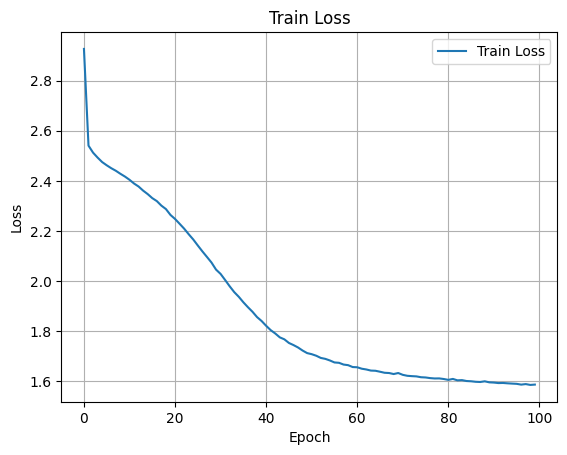

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss')
plt.grid(True)
plt.show()


In [ ]:
save_checkpoint = {
    'model_state_dict': model.state_dict(),
    'word2idx': word2idx,
    'idx2word': idx2word,
    'embedding_matrix': embedding_matrix  # Save this too
}

torch.save(save_checkpoint, 'lipreading_model_full.pth')
print("Model, vocabularies, and embedding matrix saved!")



Model, vocabularies, and embedding matrix saved!


In [ ]:
# rfd
import cv2
import numpy as np
import torch
import dlib

checkpoint = torch.load('lipreading_model_full.pth', map_location=device)

# Rebuild model architecture (reusing embedding matrix)
embedding_matrix = checkpoint['embedding_matrix']
word2idx = checkpoint['word2idx']
idx2word = checkpoint['idx2word']

model = Seq2Seq(cnn_out_dim=32*16*16, embedding_matrix=embedding_matrix, hidden_dim=128, vocab_size=len(word2idx))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
# Dlib setup
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def extract_lip_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        lips = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]
        x, y = zip(*lips)
        min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)
        lip_frame = frame[min_y:max_y, min_x:max_x]
        return cv2.resize(lip_frame, (64, 64))
    return None

def extract_words(align_path):
    words = []
    with open(align_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3 and parts[2] != 'sil':
                words.append(parts[2].lower())
    return words

def beam_search_decoder(model, encoder_output, beam_width=3, max_steps=20, penalty_weight=1.0, word_limit=6):
    beams = [(torch.zeros((1, 1), dtype=torch.long).to(device), 0.0, (None, None), [])]
    completed_sequences = []

    _, (h, c) = model.lstm_enc(encoder_output)

    for _ in range(max_steps):
        new_beams = []
        for seq, score, (prev_h, prev_c), words_so_far in beams:
            if len(words_so_far) >= word_limit:
                completed_sequences.append((seq, score))
                continue

            current_h, current_c = prev_h if prev_h is not None else h, prev_c if prev_c is not None else c
            embedded = model.embedding(seq[:, -1:])
            dec_output, (new_h, new_c) = model.lstm_dec(embedded, (current_h, current_c))
            logits = model.fc(dec_output.squeeze(1))
            log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)
            top_log_probs, top_indices = torch.topk(log_probs, beam_width)

            for i in range(beam_width):
                next_token = top_indices[i].unsqueeze(0).unsqueeze(0)
                next_score = score + top_log_probs[i].item()
                next_word = idx2word[next_token.item()]

                if next_word in words_so_far:
                    next_score -= penalty_weight
                if len(words_so_far) > 0 and next_word == words_so_far[-1]:
                    continue

                next_seq = torch.cat([seq, next_token], dim=1)
                new_words_so_far = words_so_far + [next_word]
                new_beams.append((next_seq, next_score, (new_h, new_c), new_words_so_far))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
        if not beams:
            break

    best_seq = completed_sequences[0][0] if completed_sequences else beams[0][0]
    return best_seq.squeeze(0).tolist()

# Define video & align file
video_path = '/content/bbab9s.mpg'
align_path = '/content/bbab9s.align'

actual_words = extract_words(align_path)
print("Actual Sentence:", ' '.join(actual_words))

cap = cv2.VideoCapture(video_path)
lip_frames = []
original_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    lip = extract_lip_frame(frame)
    if lip is not None:
        lip_frames.append(lip)
        original_frames.append(frame)
cap.release()

if not lip_frames:
    print("No lips detected!")
else:
    lips_tensor = torch.tensor(np.stack(lip_frames)).permute(0, 3, 1, 2).unsqueeze(0).float().to(device) / 255.0

    with torch.no_grad():
        enc_outputs = model.encoder(lips_tensor)
        predicted_indices = beam_search_decoder(
            model, enc_outputs,
            beam_width=3,
            max_steps=20,
            penalty_weight=1.0,
            word_limit=6
        )

    predicted_words = [idx2word[idx] for idx in predicted_indices if idx != word2idx['<PAD>']]
    predicted_sentence = ' '.join(predicted_words)
    print(f"Predicted Sentence: {predicted_sentence}")

    out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 25, (original_frames[0].shape[1], original_frames[0].shape[0]))
    for idx, frame in enumerate(original_frames):
        word = predicted_words[min(idx, len(predicted_words) - 1)]
        cv2.putText(frame, word, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        out.write(frame)
    out.release()
    print("Output video saved as output.mp4")


<ipython-input-50-b0ec25454aa6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('lipreading_model_full.pth', map_location=device)


Actual Sentence: bin blue by v six please
Predicted Sentence: red with e eight please again
Output video saved as output.mp4
